# Mask R-CNN - Inspect Vertebral Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pprint import pprint

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.vertebral import vertebral

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
VERTEBRAL_WEIGHTS_PATH = "/DATA5_DB8/data/sqpeng/Projects/Mask-RCNN-Vertebral-Segmentation/logs/vertebral20181030T2252/mask_rcnn_vertebral_0030.h5"  # TODO: update this path

Using TensorFlow backend.


## Configurations

In [2]:
config = vertebral.VertebralConfig()
VERTEBRAL_DIR = '/DATA5_DB8/data/sqpeng/data/vertebrae'

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset =vertebral.VertebralDataset()
dataset.load_vertebral(VERTEBRAL_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 95
Classes: ['BG', 'vertebrae']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [8]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /DATA5_DB8/data/sqpeng/Projects/Mask-RCNN-Vertebral-Segmentation/logs/vertebral20181030T2252/mask_rcnn_vertebral_0030.h5
Re-starting from epoch 30


## Run Detection

image ID: vertebrae.1916728 (27) None
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (9,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (9, 4)                min:  147.00000  max:  895.00000  int32
gt_mask                  shape: (1024, 1024, 9)       min:    0.00000  max:    1.00000  bool


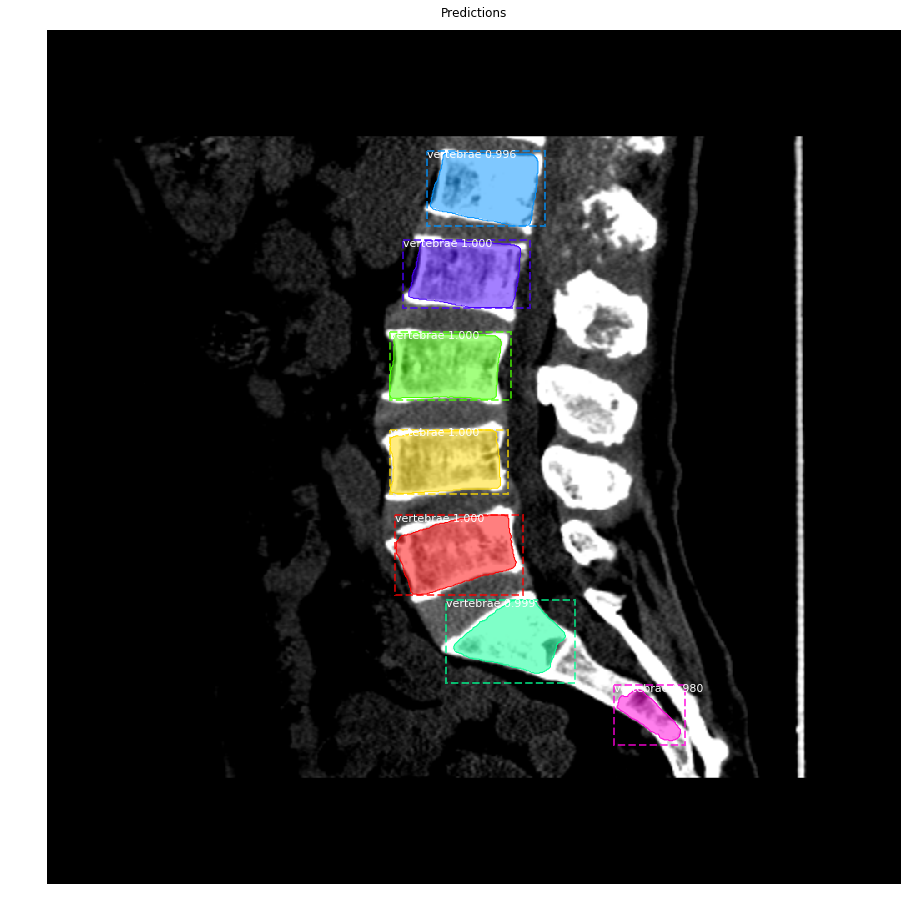

In [9]:
# image_id = random.choice(dataset.image_ids)
image_id = 27
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Color Splash

This is for illustration. You can call `vertebral.py` with the `test` option to get better images without the black padding.

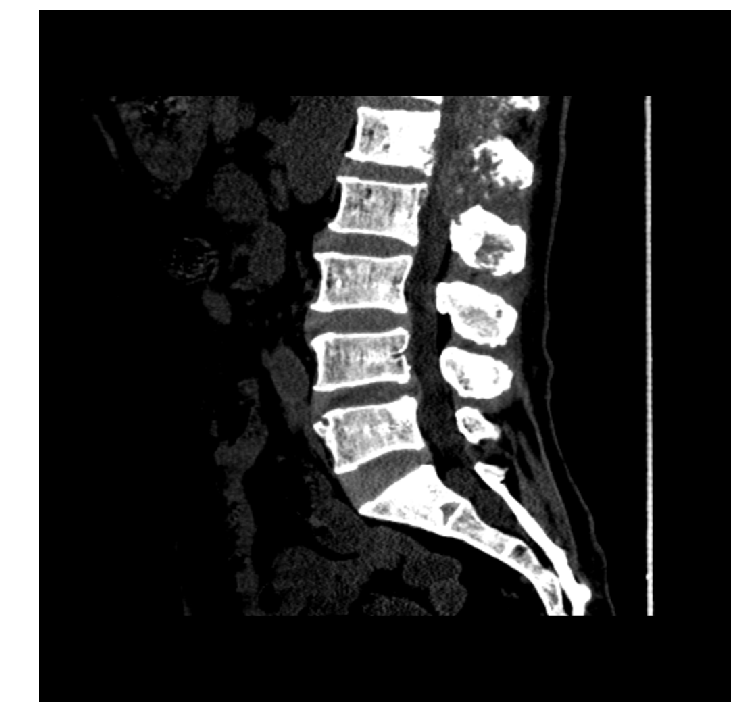

In [10]:
splash = vertebral.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [11]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.98841  max:    1.88673  float64
positive_anchors         shape: (16, 4)               min:  146.74517  max:  882.62742  float64
negative_anchors         shape: (240, 4)              min:  -74.50967  max: 1066.50967  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (16, 4)               min:  147.00000  max:  895.00006  float32


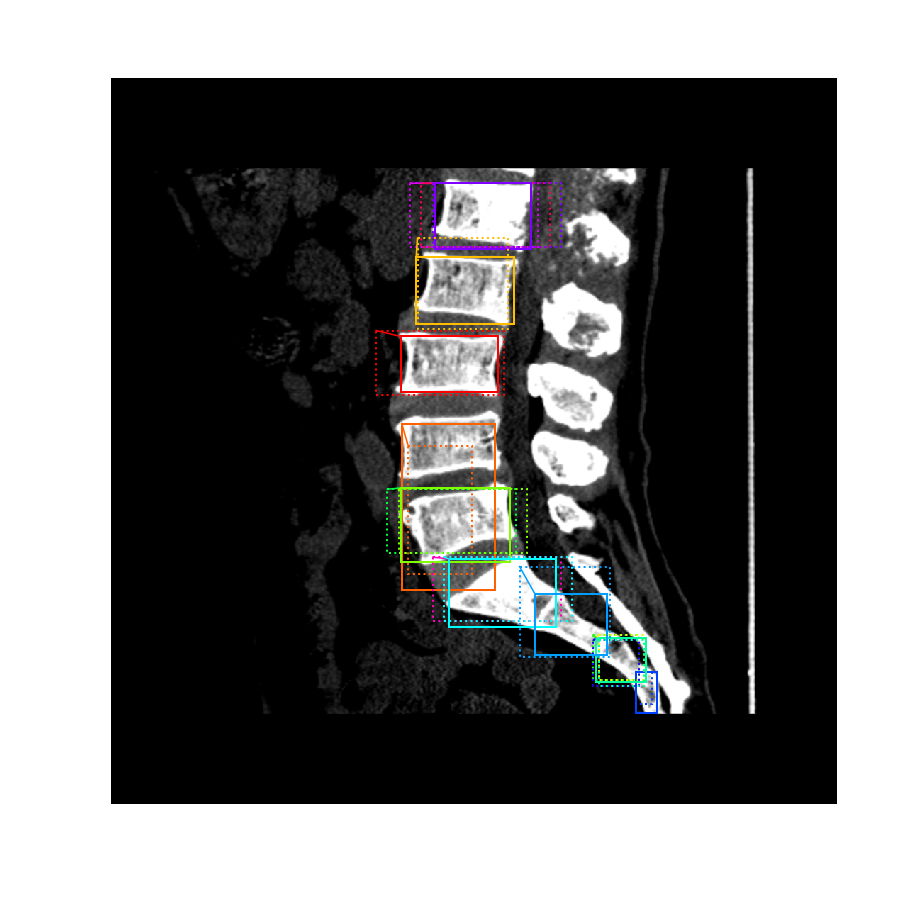

In [12]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [13]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.10365  max:    1.05719  float32
refined_anchors          shape: (1, 6000, 4)          min:    0.01306  max:    1.13674  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.01306  max:    1.00000  float32
post_nms_anchor_ix       shape: (853,)                min:    0.00000  max: 5990.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


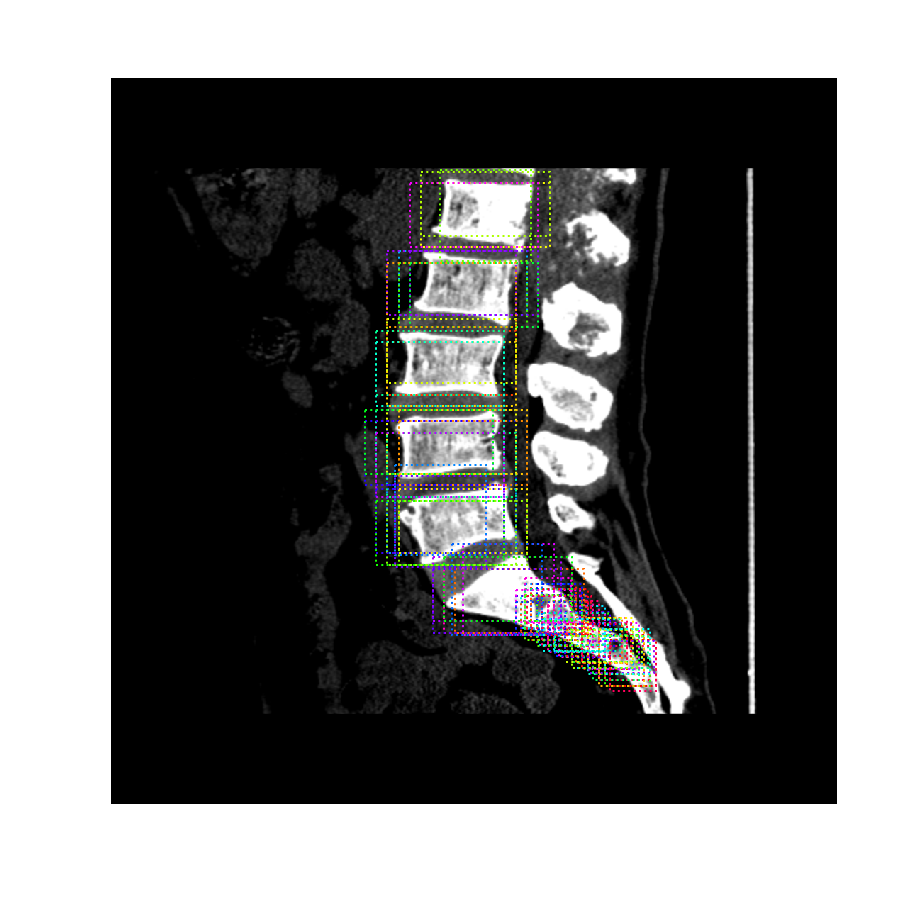

In [14]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

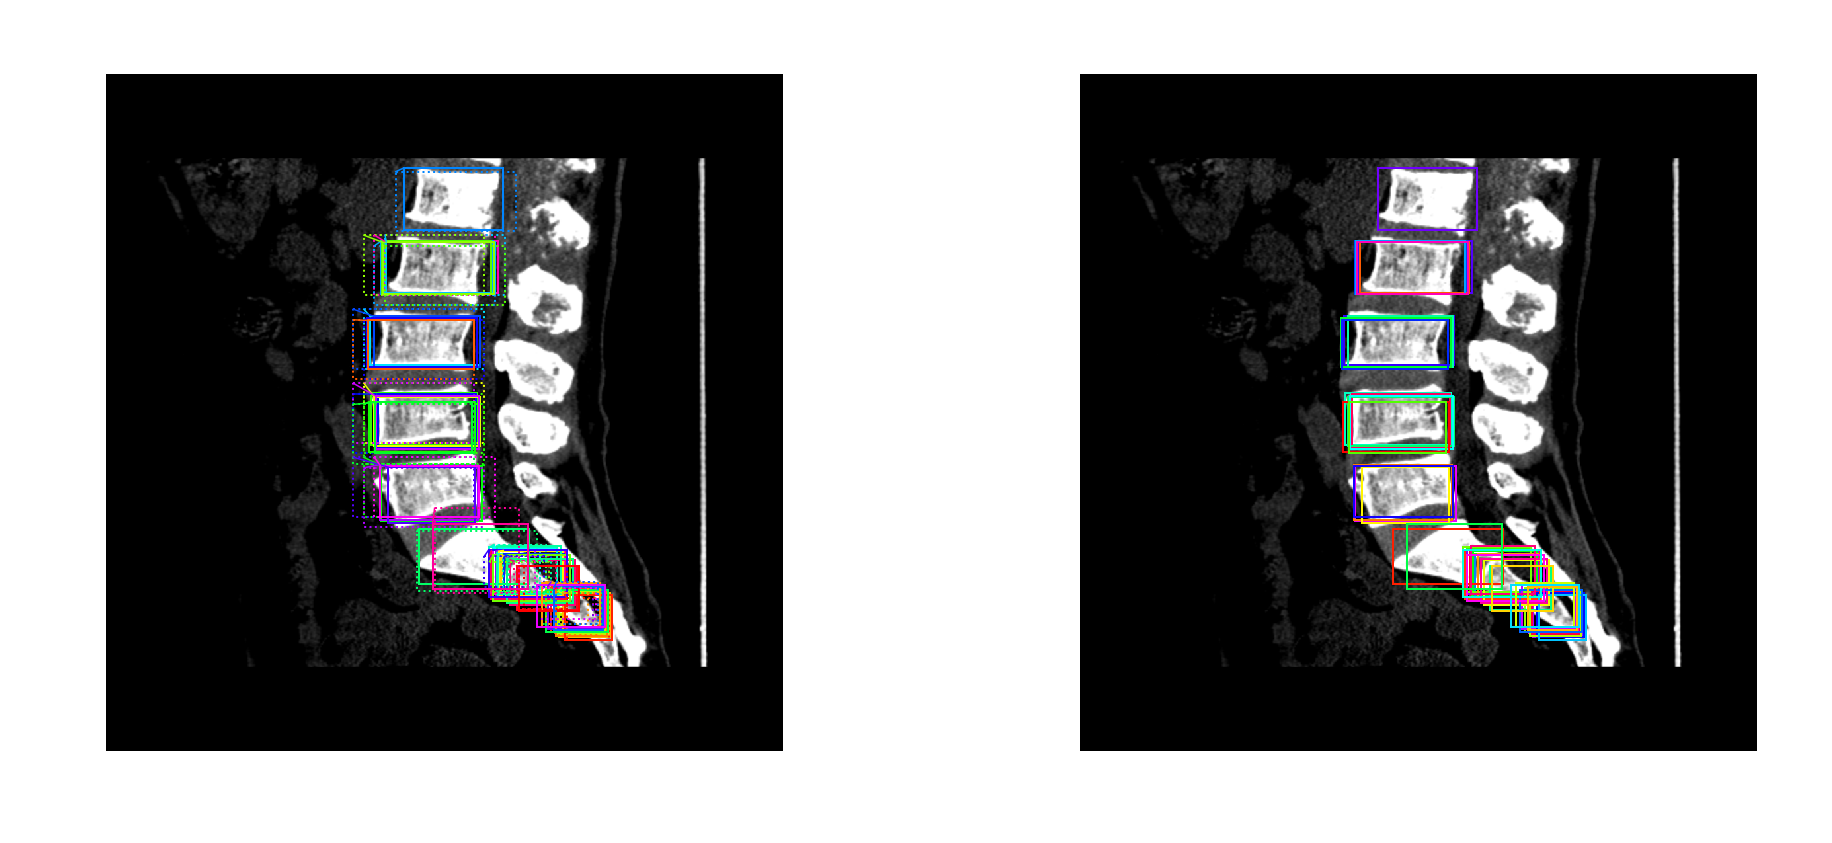

In [15]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

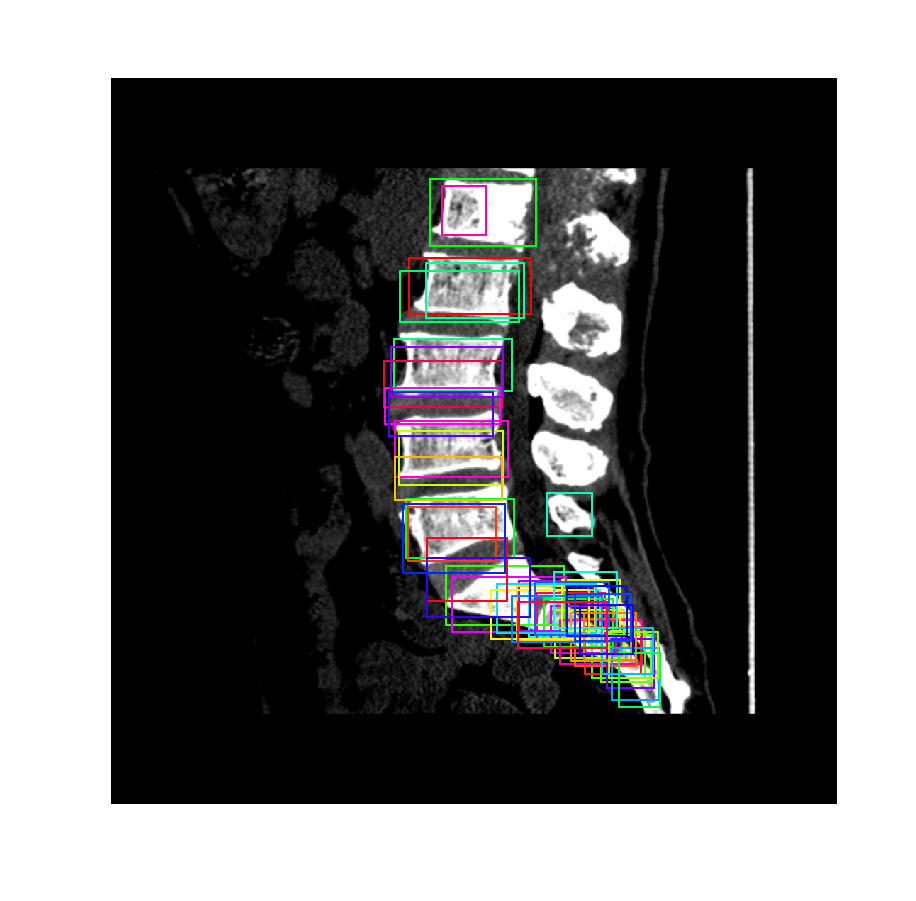

In [16]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

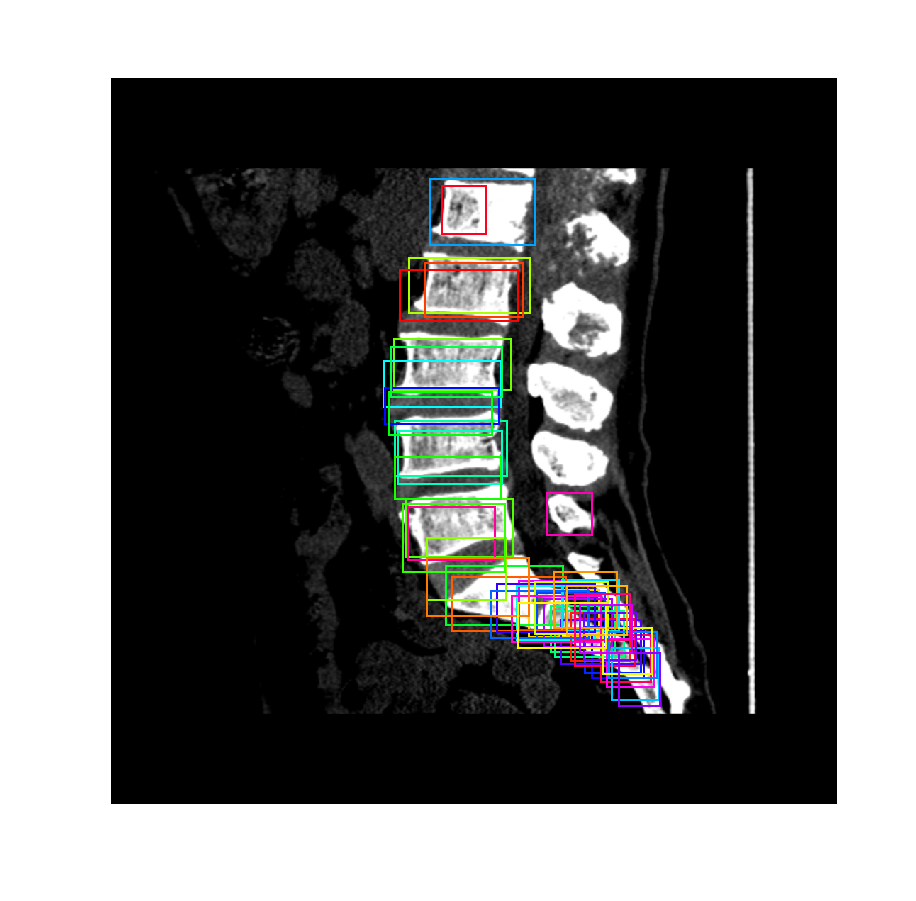

In [17]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [18]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -4.76647  max:    4.30535  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


7 detections: ['vertebrae' 'vertebrae' 'vertebrae' 'vertebrae' 'vertebrae' 'vertebrae'
 'vertebrae']


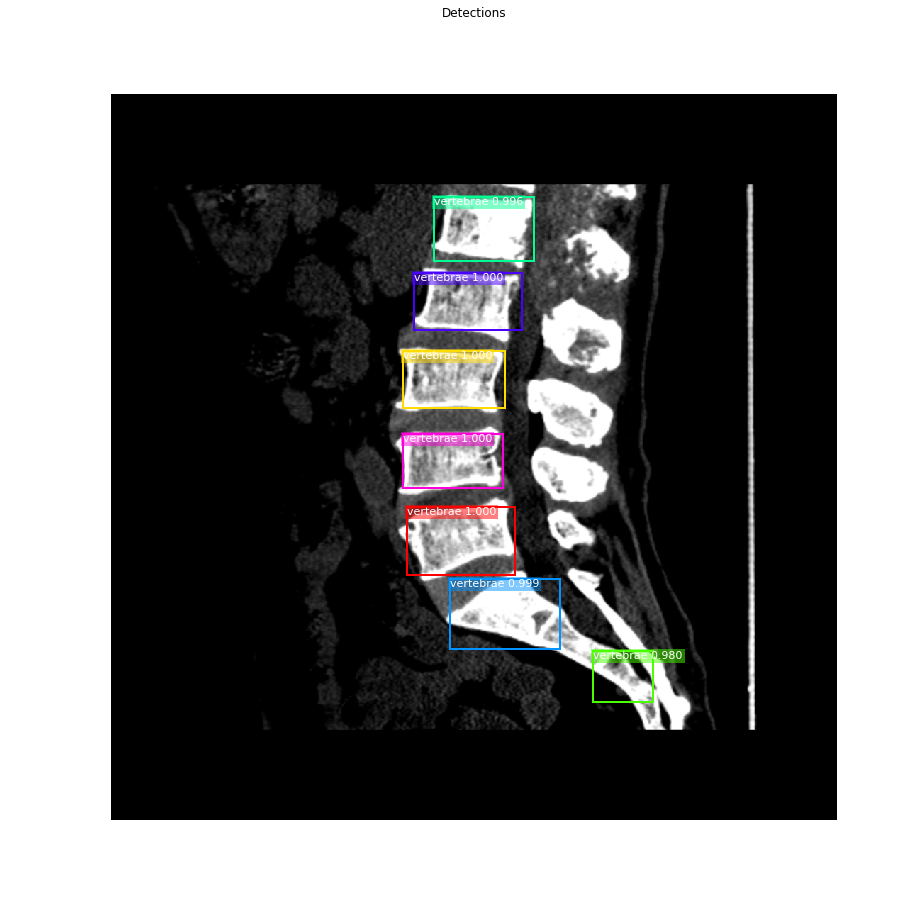

In [19]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [20]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

853 Valid proposals out of 1000
130 Positive ROIs
[('BG', 870), ('vertebrae', 130)]


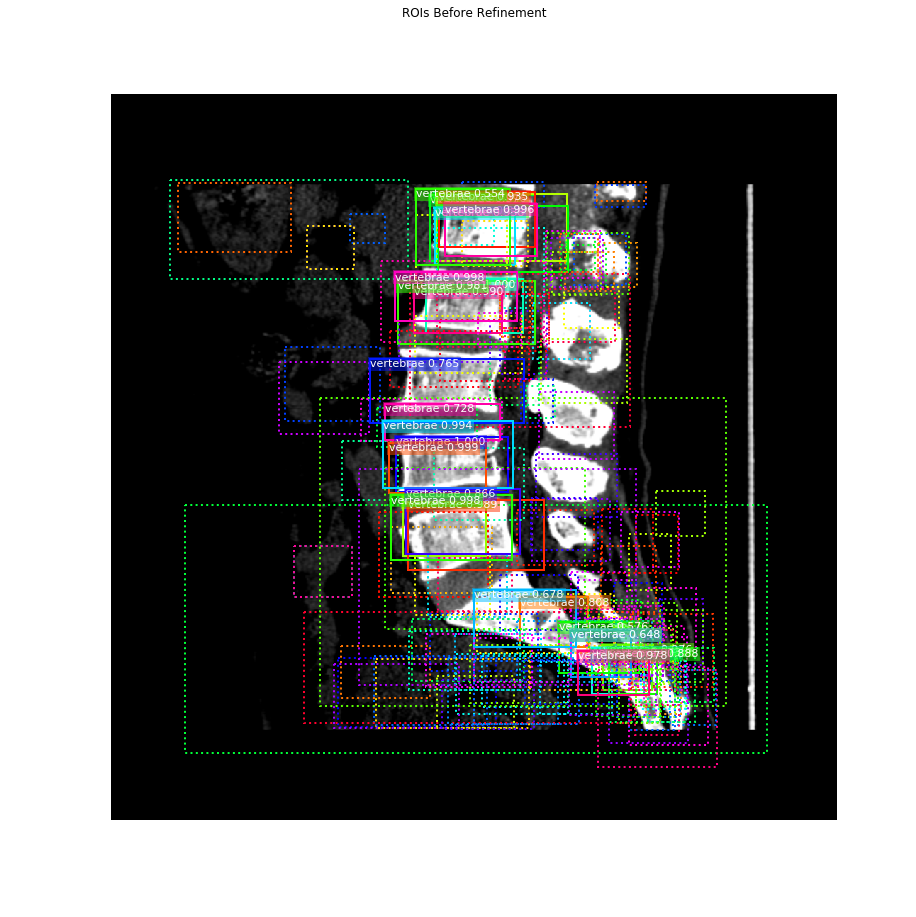

In [21]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -4.76647  max:    2.77020  float32
refined_proposals        shape: (1000, 4)             min:  -56.00000  max: 1162.00000  int32


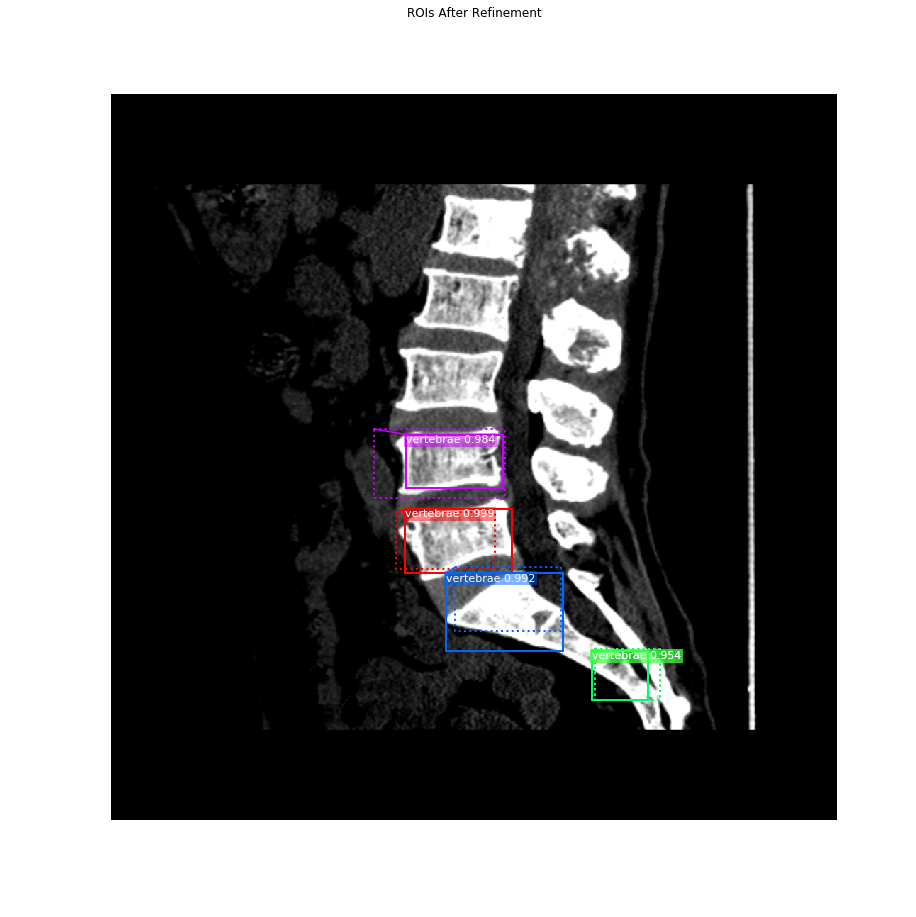

In [22]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [23]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 130 detections:
[  0   1   2   3   4   5   6   8   9  11  12  13  14  15  16  17  18  19
  20  22  23  26  28  31  33  37  38  39  47  50  55  60  63  64  65  68
  76  77  82  83  86  89  90  94  98  99 108 111 115 119 124 129 133 136
 138 141 142 155 157 159 161 164 168 169 170 173 174 178 179 183 184 188
 190 196 198 205 209 216 227 241 250 253 256 260 273 310 313 316 332 333
 345 346 347 353 359 360 368 379 389 390 403 413 415 426 436 438 489 499
 511 522 529 535 543 557 569 571 577 581 596 631 637 716 752 769 786 789
 792 819 822 849]


In [24]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 80:
[  1   2   3   4   5   6   9  11  12  13  18  23  28  31  37  39  47  55
  60  63  64  68  76  77  83  86  89  90  94 108 111 119 124 133 136 138
 141 155 157 159 164 168 178 183 198 205 209 216 256 260 273 310 313 333
 345 346 347 359 360 368 379 390 413 415 426 436 499 511 522 529 535 557
 569 581 596 716 786 789 792 849]


#### Per-Class Non-Max Suppression

In [25]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

vertebrae             : [  1   2   3   4   5   6   9  11  12  13  18  23  28  31  37  39  47  55
  60  63  64  68  76  77  83  86  89  90  94 108 111 119 124 133 136 138
 141 155 157 159 164 168 178 183 198 205 209 216 256 260 273 310 313 333
 345 346 347 359 360 368 379 390 413 415 426 436 499 511 522 529 535 557
 569 581 596 716 786 789 792 849] -> [ 1  4 31  5 11 94  9]

Kept after per-class NMS: 7
[ 1  4  5  9 11 31 94]


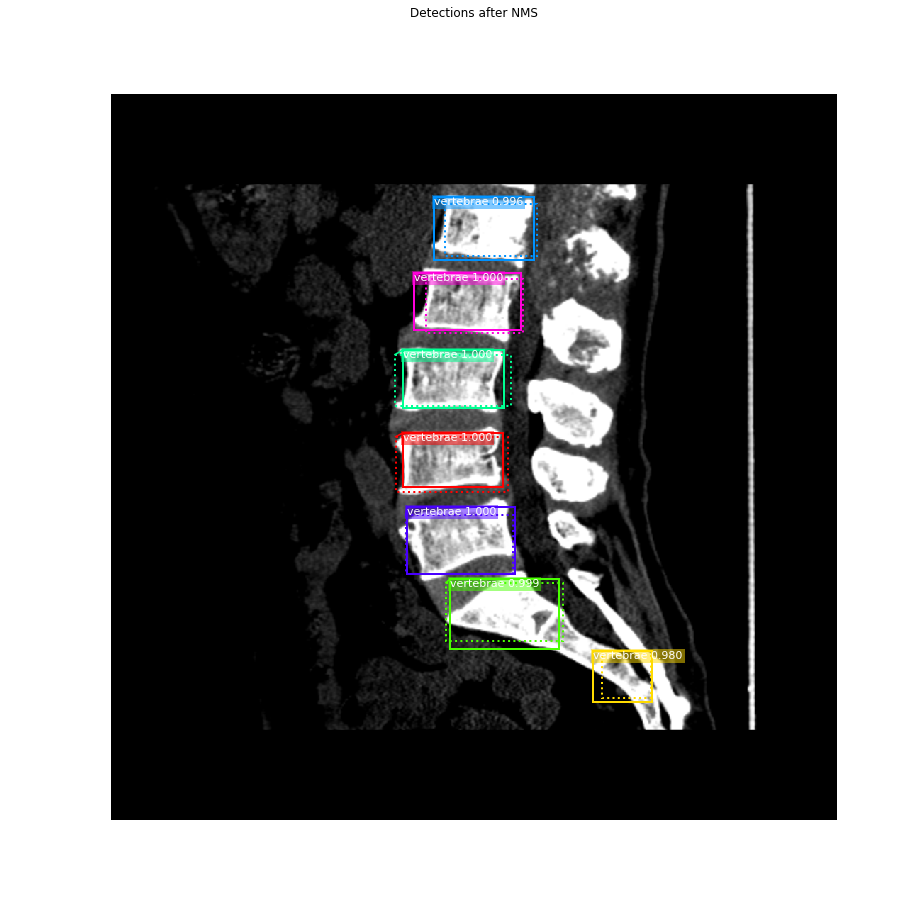

In [26]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

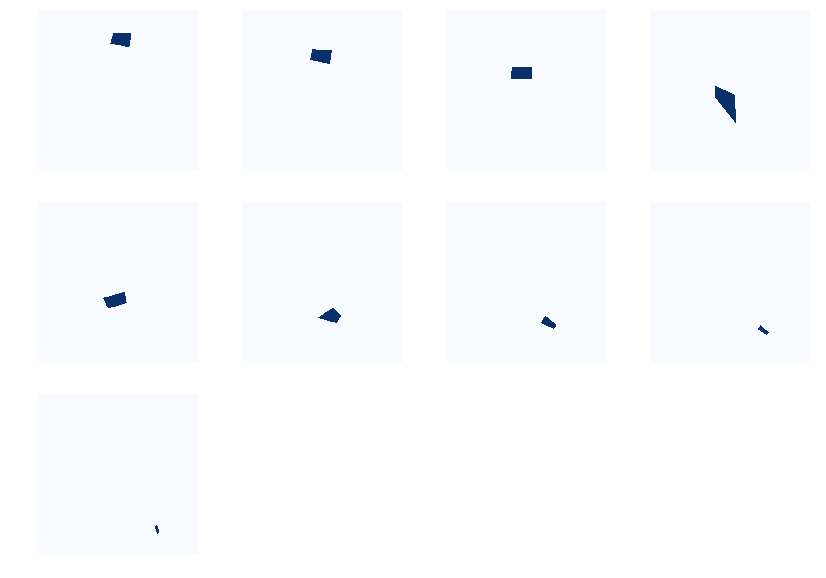

In [27]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [28]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
7 detections: ['vertebrae' 'vertebrae' 'vertebrae' 'vertebrae' 'vertebrae' 'vertebrae'
 'vertebrae']


In [29]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (7, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (7, 1024, 1024)       min:    0.00000  max:    1.00000  bool


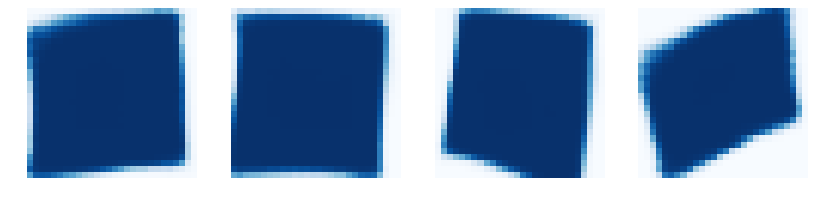

In [30]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

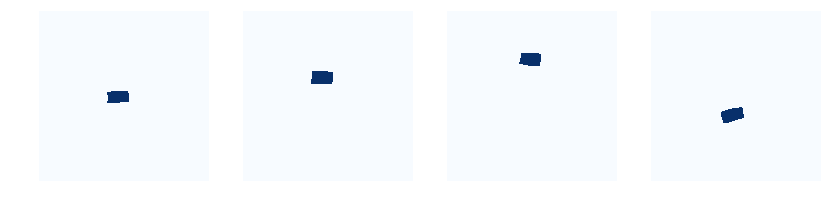

In [31]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [32]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   25.27218  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.80074  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   58.07145  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -6.12745  max:   53.00662  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


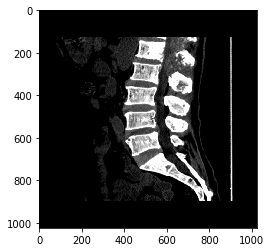

In [33]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

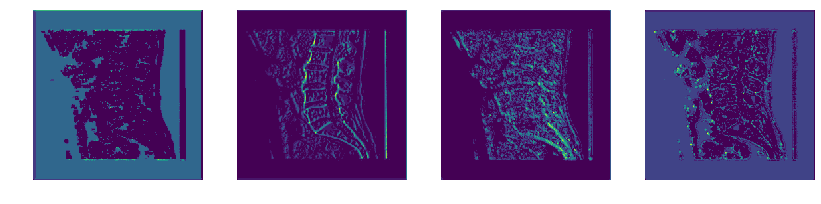

In [34]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

## 去掉冗余ROI

先去除附属器官的FP

这里需要制定多个规则：

1. 偏离拟合曲线太远的

2. 在竖直方向上没有重叠的

3. 保证横向没有重叠的

然后再去除椎间盘的FP

可以根据大小比例来判断

image ID: vertebrae.1105516 (83) None
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[0, 6310, 7320, 7753, 8054, 4626, 4593, 6895, 5997, 3484]


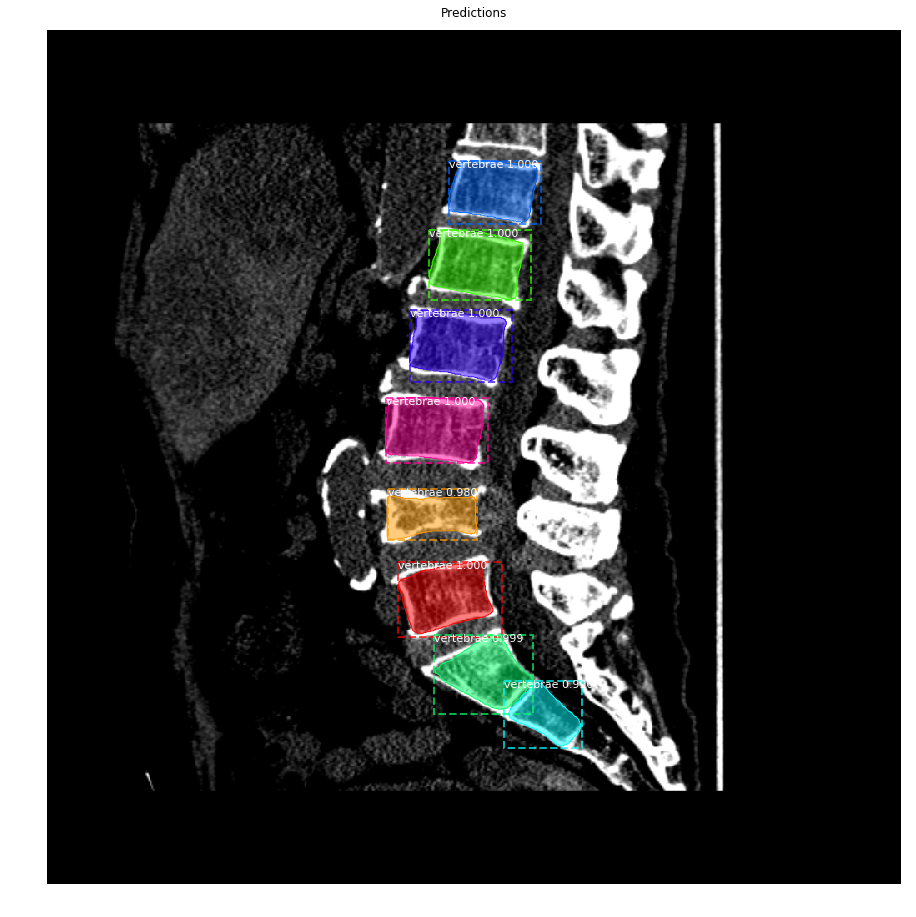

In [55]:
# image_id = random.choice(dataset.image_ids)
image_id = 83  # 83 | 69 | 89 | 48 | 38 | 32 
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

# pprint(r['rois'])

# 对每个roi区域的怀疑，编号与r['rois']相同
suspect_dict = {i: 0 for i in range(len(r['rois']))}

# ------------------------------------ 曲线拟合 ----------------------------------
# 将ROI从上到下排序，每个tuple三个值： 1. 序号； 2. ROI区域坐标 y1, x1, y2, x2； 3. 中心点坐标: y_mean, x_mean
ordered_rois = zip(range(len(r['rois'])),
                   r['rois'],
                   [((r['rois'][i][0] + r['rois'][i][2]) // 2, (r['rois'][i][1] + r['rois'][i][3]) // 2)
                    for i in range(len(r['rois']))])
ordered_rois = list(sorted(ordered_rois, key=lambda x: x[1][0]))

# pprint(ordered_rois)

# 用三次曲线拟合中心点
x = np.array([xx[2][0] for xx in ordered_rois])
y = np.array([xx[2][1] for xx in ordered_rois])

f1 = np.polyfit(x, y, 3)
p1 = np.poly1d(f1)

y_vals = p1(x)

# 计算每个中心点到拟合曲线的距离
dist = [9999999] * len(ordered_rois)
ordered_dist = []

for i, roi in enumerate(ordered_rois):
    index, _, (x_m, y_m) = roi
    # 遍历所有点，求点到曲线的最近距离
    for xx in range(x[0], x[-1] + 1):
        dist[index] = min(dist[index], round(math.sqrt((x_m - xx) ** 2 + (y_m - p1(xx)) ** 2), 2))
    
    # 越远的点怀疑程度越大
    if dist[index] > 140:
        suspect_dict[index] += 3
    elif dist[index] > 80:
        suspect_dict[index] += 1
    elif dist[index] > 20:
        suspect_dict[index] -= 1
    elif dist[index] > 10:
        suspect_dict[index] -= 3
    else:
        suspect_dict[index] -= 4
        
    ordered_dist.append(dist[index])
    
# print(u'每个中心点到拟合曲线的距离：', ordered_dist)

# -------------------------------------- 竖直方向判断 --------------------------------
vertical_overlap_dict = {}

for i, roi in enumerate(ordered_rois):
    index, (_, s1, _, e1), _ = roi

    overlap_count = 0
    
    for j, o_roi in enumerate(ordered_rois):
        o_index, (_, s2, _, e2), _ = o_roi
        # 跳过同一个roi
        if o_index == index:
            continue
            
        # 判断 roi 和 o_roi 的重叠部分
        if max(s1, s2) < min(e1, e2):  # 有交集
            IoU = (e1 - s1 + e2 - s2 - (max(e1, s1, e2, s2) - min(e1, s1, e2, s2))) / (max(e1, s1, e2, s2) - min(e1, s1, e2, s2))
        else:  # 无交集
            IoU = 0
        
        if IoU > 0.5:
            overlap_count += 1
            
    vertical_overlap_dict[index] = overlap_count
            
    if overlap_count > 4:
        suspect_dict[index] -= 3
    elif overlap_count > 2:
        suspect_dict[index] -= 2
    elif overlap_count > 1:
        suspect_dict[index] -= 1
    elif overlap_count == 0:
        suspect_dict[index] += 1

# -------------------------------------- 水平方向判断 --------------------------------

# 去掉 suspect dict > 0 的roi
for k, v in suspect_dict.items():
    if v > 0:
        r['rois'][k] = np.array([0, 0, 0, 0])

for i, roi in enumerate(ordered_rois):
    index, (s1, _, e1, _), _ = roi
    if suspect_dict[index] > 0:
        continue

    horizontal_overlap_count = 0
    
    for j, o_roi in enumerate(ordered_rois):
        o_index, (s2, _, e2, _), _ = o_roi
        if suspect_dict[o_index] > 0:
            continue
        
        # 跳过同一个roi
        if o_index == index:
            continue
            
        # 判断 roi 和 o_roi 的重叠部分
        if max(s1, s2) < min(e1, e2):  # 有交集
            IoU = (e1 - s1 + e2 - s2 - (max(e1, s1, e2, s2) - min(e1, s1, e2, s2))) / (max(e1, s1, e2, s2) - min(e1, s1, e2, s2))
        else:  # 无交集
            IoU = 0
        
        # 出现了冗余ROI
        if IoU > 0.5:
            if vertical_overlap_dict[index] < vertical_overlap_dict[o_index]:
                r['rois'][index] = np.array([0, 0, 0, 0])
            else:
                r['rois'][o_index] = np.array([0, 0, 0, 0])
                
# -------------------------------------- 然后去除椎间盘 -------------------------------
# 将ROI从上到下排序，每个tuple三个值： 1. 序号； 2. ROI； 3. mask； 4. mask 大小
ordered_rois = zip(range(len(r['rois'])),
                   r['rois'],
                   [r['masks'][:, :, i] for i in range(len(r['rois']))],
                   [np.sum(r['masks'][:, :, i]) if np.any(r['rois'][i]) else 0 for i in range(len(r['rois']))])
ordered_rois = list(sorted(ordered_rois, key=lambda x: x[1][0]))

# pprint(ordered_rois)

# 面积列表
region_list = [x[3] for x in ordered_rois]

print(region_list)

for i, roi in enumerate(ordered_rois):
    index, box, mask, region = roi
        
    # 不考虑第一个和最后一个
    if i == 0 or i == len(ordered_rois) - 1 or region == 0:
        continue
    
    # 如果这个ROI区域小于相邻两个ROI的60%，就认为是椎间盘
    if region_list[i] < region_list[i - 1] * 0.6 and region_list[i] < region_list[i + 1] * 0.6:
        r['rois'][index] = np.array([0, 0, 0, 0])
        
    # 如果这个ROI区域只小于相邻某个ROI的60%，需要进一步判断
    if region_list[i] < region_list[i - 1] * 0.6 or region_list[i] < region_list[i + 1] * 0.6:
        added_mask = mask.astype(np.int64) + ordered_rois[i - 1][2].astype(np.int64)
        intersection = np.sum(np.isin(added_mask, [2]))
        if intersection > 100:
            r['rois'][index] = np.array([0, 0, 0, 0])
        
        added_mask = mask.astype(np.int64) + ordered_rois[i + 1][2].astype(np.int64)
        intersection = np.sum(np.isin(added_mask, [2]))
        if intersection > 100:
            r['rois'][index] = np.array([0, 0, 0, 0])
    
# ----------------------------------------------------------------------

# 作图
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")